In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery

credential_path = r'../../BQ_Keypath/portfolio-331917-9f920a11ce56.json'
client = bigquery.Client.from_service_account_json(credential_path)

# define helper functions
def getQueryAsDF(query):
    return client.query(query).result().to_dataframe()

def getTableSchema(table):
    return client.get_table(table).schema

## 1. Population Growth Over Time
We will be looking at users signup rate year by year. This will give us insight for the platform growth. 

In [3]:
# understanding users table's schema

schema = getTableSchema('bigquery-public-data.stackoverflow.users')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('age', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('location', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, (), None)]

In [4]:
# since all field are NULLABLE modes, checking for nulls 
query = """
            SELECT 
                COUNT(*) AS null_count
            FROM
                `bigquery-public-data.stackoverflow.users`
            WHERE
                id IS NULL
                OR creation_date IS NULL
                OR last_access_date IS NULL;
        """

result = getQueryAsDF(query)
result

,null_count
0,0


In [48]:
# user signup count by year
query = """
            SELECT 
                EXTRACT (YEAR FROM creation_date) AS year,
                COUNT(*) AS signup_count
            FROM `bigquery-public-data.stackoverflow.users`
            GROUP BY 1
        """

result = getQueryAsDF(query)
result

,year,signup_count
0,2008,21646
1,2009,78007
2,2010,199205
3,2011,358720
4,2012,678857
5,2013,1122387
6,2014,1174726
7,2015,1252388
8,2016,1515482
9,2017,1726646


In [63]:
users_count = result['signup_count'].values

total_users_by_year = []
growth_perc = []
total_users_by_year.append(users_count[0])
growth_perc.append(100)

for i in range(len(users_count)):
    if i < len(users_count)-1:
        index = i+2
        total_users_by_year.append(np.sum(users_count[:index]))
        
        growth_perc.append(round(total_users_by_year[index-1]/total_users_by_year[i] * 100,2))

df = result
df['total_user_by_year'] = total_users_by_year
df['growth_perc'] = growth_perc
df

,year,signup_count,total_user_by_year,growth_perc
0,2008,21646,21646,100.00
1,2009,78007,99653,460.38
2,2010,199205,298858,299.90
3,2011,358720,657578,220.03
4,2012,678857,1336435,203.24
5,2013,1122387,2458822,183.98
6,2014,1174726,3633548,147.78
7,2015,1252388,4885936,134.47
8,2016,1515482,6401418,131.02
9,2017,1726646,8128064,126.97


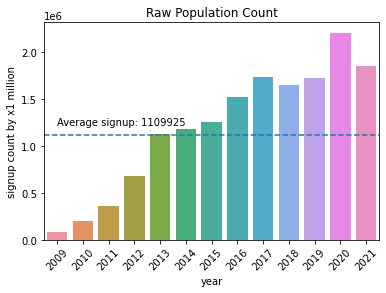

In [69]:
sns.barplot(data = users_growth[1:], x = 'year', y = 'signup_count')
avg_growth_count = np.average(users_growth['signup_count'])
text_avg_growth_count = 'Average signup: {}'.format(round(avg_growth_count))
plt.axhline(avg_growth_count, ls = '--')
plt.text(0, avg_growth_count * 1.1, text_avg_growth_count)
plt.title('Raw Population Count')
plt.ylabel('signup count by x1 million')
plt.xticks(rotation = 45)
plt.savefig('test.pdf')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '2009'),
  Text(1, 0, '2010'),
  Text(2, 0, '2011'),
  Text(3, 0, '2012'),
  Text(4, 0, '2013'),
  Text(5, 0, '2014'),
  Text(6, 0, '2015'),
  Text(7, 0, '2016'),
  Text(8, 0, '2017'),
  Text(9, 0, '2018'),
  Text(10, 0, '2019'),
  Text(11, 0, '2020'),
  Text(12, 0, '2021')])

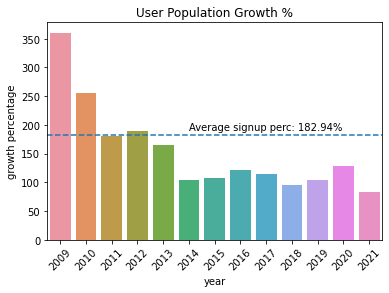

In [70]:
# excluding 2008 as it was the launch year.
sns.barplot(data = users_growth[1:], x = 'year', y = 'growth_perc')
avg_growth_perc = np.average(growth_perc[1:]) # adding reference line for average growth
text_avg_growth_perc = 'Average signup perc: {}{}'.format(round(avg_growth_perc,2),'%')
plt.axhline(avg_growth_perc, ls = '--')
plt.text(5, 190, text_avg_growth_perc)
plt.title('User Population Growth %')
plt.ylabel('growth percentage')
plt.xticks(rotation = 45)